In [5]:
import pandas as pd
import glob
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import ruptures as rpt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy import signal
import seaborn as sns

# setup matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16, 4)
plt.rcParams['figure.dpi'] = 100

In [3]:
link_to_dataset = 'validation_dataset.csv'
df = pd.read_csv(link_to_dataset, header=None, index_col=0).reset_index().drop([0, 1, 2], axis=1)

df_piezo = df[4].copy()
df_encoder = df[3].copy()

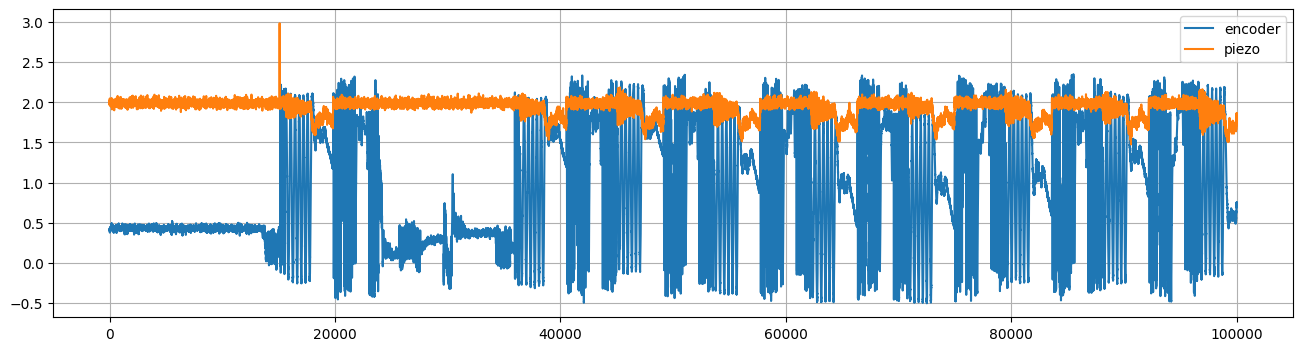

In [6]:
start, end = 0, 100000

df_encoder[start: end].plot(label='encoder')
df_piezo[start: end].plot(label='piezo')
plt.legend()
plt.show()

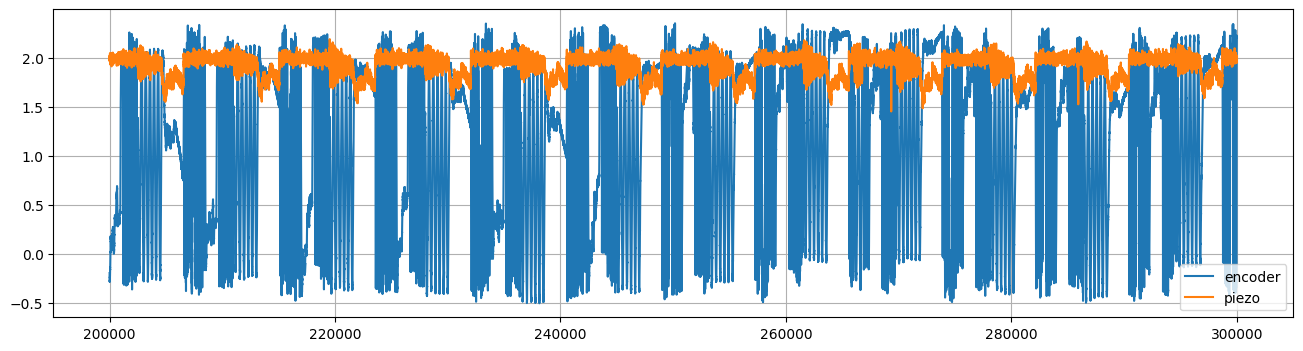

In [27]:
start, end = 200000, 300000

df_encoder[start: end].plot(label='encoder')
df_piezo[start: end].plot(label='piezo')
plt.legend()
plt.show()

### Envelope algorithm

In [53]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1


    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s)
        # pre-sorting of locals min based on relative position with respect to s_mid
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid
        lmax = lmax[s[lmax]>s_mid]


    # global max of dmax-chunks of locals max
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]

    return lmin, lmax

def extend_envelope(df_np, env_indices_np):
    extend_list = []

    for idx, val in enumerate(env_indices_np):
        if idx == len(env_indices_np)-1:
            extend_list.extend([df_np[val] for _ in range(len(df_np) - val)])
            return extend_list
        if idx == 0 and env_indices_np[0] != 0:
            extend_list.extend([df_np[val] for _ in range(val)])
        else:
            extend_list.extend([df_np[val] for _ in range(env_indices_np[idx+1] - val)])

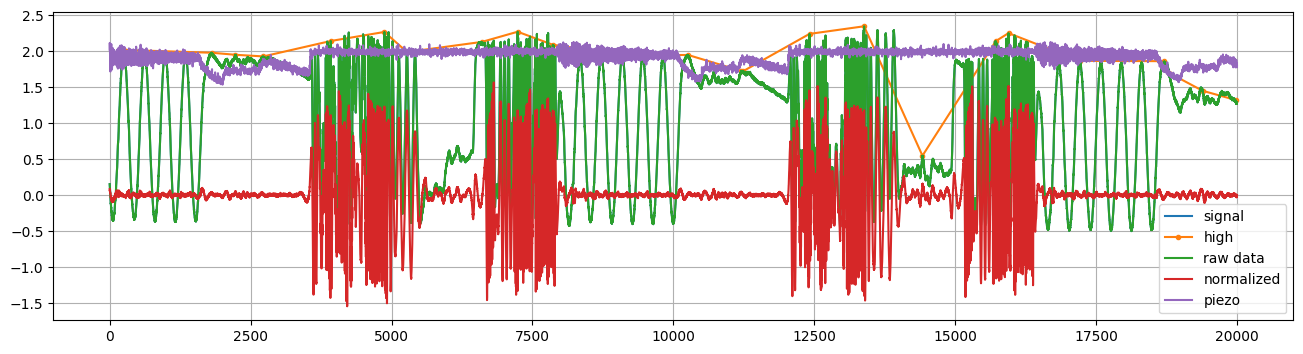

In [62]:
def butter_highpass(cut=0.5, order=5):
    b, a = signal.butter(order, cut, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cut, order=5):
    b, a = butter_highpass(cut, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

high_idx, low_idx = hl_envelopes_idx(df_encoder[220000:240000].values, dmin=200, dmax=200)

t = np.array([i for i in range(len(df_encoder[220000:240000]))])

plt.plot(df_encoder[220000:240000].values, label='signal')
plt.plot(t[low_idx], df_encoder[220000:240000].values[low_idx], label='high', marker='.', linestyle='-')

z_normalize = butter_highpass_filter(data=df_encoder[220000:240000], cut=0.01, order=5)
plt.plot(df_encoder[220000:240000].values, label='raw data')
plt.plot(z_normalize, label='normalized')
plt.plot(df_piezo[220000:240000].values, label='piezo')
plt.legend()
plt.show()

In [5]:
import pandas as pd
import numpy as np

df = pd.DataFrame([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9],
                   [np.nan, np.nan, np.nan]],
                  columns=['A', 'B', 'C'])

df.agg(func=['sum', 'min'], axis = 1)

,sum,min
0,6.0,1.0
1,15.0,4.0
2,24.0,7.0
3,0.0,NaN


In [6]:
import pandas as pd
import numpy as np

df = pd.DataFrame([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9],
                   [np.nan, np.nan, np.nan]],
                  columns=['A', 'B', 'C'])

df.agg(func=['sum', 'min'], axis = 0)

,A,B,C
sum,12.0,15.0,18.0
min,1.0,2.0,3.0


In [7]:
df

,A,B,C
0,1.0,2.0,3.0
1,4.0,5.0,6.0
2,7.0,8.0,9.0
3,NaN,NaN,NaN


In [11]:
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})

In [12]:
df

,Animal,Max Speed
0,Falcon,380.0
1,Falcon,370.0
2,Parrot,24.0
3,Parrot,26.0


In [14]:
df.groupby(by='Animal').sum('Max Speed')

,Max Speed
Animal,
Falcon,750.0
Parrot,50.0
